In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.integrate as sint

In [2]:
#gamma = [p, e, i, Omg, omg, f]

G = 6.67e-11
c = 3e8
day = 3600*24
H0 = 2.27e-18

p0 = ((10*day)**2 * G * 2*2e30/4*np.pi**2)**(1/3)

gamma_0 = [p0, 0.1, 0.01, 0, np.pi/6, np.pi/6]
args_0 = [1.4*2e30, 1.4*2e30]

from scipy.integrate import solve_ivp
t_eval = np.linspace(0,4000*day,500)

p = sp.symbols('p')
e = sp.symbols('e')
inc = sp.symbols(r'\iota')
Omg = sp.symbols(r'\Omega')
omg = sp.symbols(r'\omega')
f = sp.symbols('f')
m1 = sp.symbols(r'm_1')
m2 = sp.symbols(r'm_2')
t = sp.symbols('t')
gamma = sp.Array([p,e,inc,Omg,omg,f])
args = sp.Array([m1,m2])
freq = sp.symbols(r'\nu')
#c = sp.symbols('c')

M_tot = m1+m2

In [3]:
# Trying to evolve gamma_0, gamma_1, phi simultaneously
def M_mat(gamma, args):
    p,e,inc,Omg,omg,f = gamma
    m1,m2 = args
    M_tot = m1+m2
    
    M = sp.Matrix(np.zeros((6,3)))
    M[0,1] = 2*p/(1 + e*sp.cos(f))
    M[1,0] = sp.sin(f)
    M[1,1] = (2*sp.cos(f) + e + e*sp.cos(f)**2)/(1+e*sp.cos(f))
    M[2,2] = sp.cos(omg+f)/(1+e*sp.cos(f))
    M[3,2] = sp.sin(omg+f)/(sp.sin(inc) + e*sp.sin(inc)*sp.cos(f))
    M[4,0] = -sp.cos(f)/e
    M[4,1] = sp.sin(f) * (2+sp.cos(f))/e/(1+e*sp.cos(f))
    M[4,2] = -sp.cot(inc) * sp.sin(omg+f)/(1+e*sp.cos(f))
    M[5,0] = sp.cos(f)/e
    M[5,1] = -sp.sin(f) * (2+e*sp.cos(f)) / e / (1+e*sp.cos(f))
    M *= sp.sqrt(p/(G*M_tot))

    return M

def E_mat(gamma, args):
    p,e,inc,Omg,omg,f = gamma
    m1,m2 = args
    M_tot = m1+m2
    
    r_hat = [sp.cos(Omg)*sp.cos(omg+f) - sp.cos(inc)*sp.sin(Omg)*sp.sin(omg+f), sp.sin(Omg)*sp.cos(omg+f) + sp.cos(inc)*sp.cos(Omg)*sp.sin(omg+f), sp.sin(inc)*sp.sin(omg+f)]
    theta_hat = [-sp.cos(Omg)*sp.sin(omg+f) - sp.cos(inc)*sp.sin(Omg)*sp.cos(omg+f), -sp.sin(Omg)*sp.sin(omg+f) + sp.cos(inc)*sp.cos(Omg)*sp.cos(omg+f), sp.sin(inc)*sp.cos(omg+f)]
    z_hat = [sp.sin(inc)*sp.sin(Omg), -sp.sin(inc)*sp.cos(Omg), sp.cos(inc)]
    E = sp.Matrix([r_hat, theta_hat, z_hat]).T

    return E

def det_evo(t, gamma, args):

    p,e,inc,Omg,omg,f = gamma
    m1,m2 = args
    M_tot = m1+m2
    
    eta = m1*m2/M_tot**2
    P = sp.sqrt(4*sp.pi**2/G/M_tot * (p/(1-e**2))**3)
    g = sp.sqrt(1-e**2)
    vp = (2*sp.pi*G*M_tot/P)**(1/3)
    
    F_r = (2*sp.pi/P)**2 * vp**2/g**8 * (1 + e*sp.cos(f))**3 * (3 - eta - e**2*(1+3*eta) + e*(2-4*eta)*sp.cos(f) + e**2 * (8-eta)*sp.sin(f)**2/2)
    F_theta = (2*sp.pi/P)**2 * 2*e*vp**2/g**8 *sp.sin(f) * (1+e*sp.cos(f))**4 * (2-eta)
    F_l = 0
    
    acc = G*M_tot/c**4 * sp.Array([F_r, F_theta, F_l])
    return acc

def Omega_gw(f):
    
    f_peak = 1.e-4
    return 1.e-5 * (f/f_peak)**3. * ((4. + 3.*(f/f_peak)**2.) / 7.)**-3.5

def M_ab(gamma, args):
    """
    From Eqn (4)
    """
    p, e, i, Omg, omg, f = gamma
    m1,m2 = args
    m = m1+m2

    M = np.zeros((6,3))
    M[0,1] = 2*p/(1 + e*np.cos(f))
    M[1,0] = np.sin(f)
    M[1,1] = (2*np.cos(f) + e + e*np.cos(f)**2)/(1+e*np.cos(f))
    M[2,2] = np.cos(omg+f)/(1+e*np.cos(f))
    M[3,2] = np.sin(omg+f)/(np.sin(i) + e*np.sin(i)*np.cos(f))
    M[4,0] = -np.cos(f)/e
    M[4,1] = np.sin(f) * (2+np.cos(f))/e/(1+e*np.cos(f))
    M[4,2] = -1/np.tan(i) * np.sin(omg+f)/(1+e*np.cos(f))
    M[5,0] = np.cos(f)/e
    M[5,1] = -np.sin(f) * (2+e*np.cos(f)) / e / (1+e*np.cos(f))

    return np.sqrt(p/G/m) * M

def e_ab(gamma):
    """
    From Eqn (2) & Eqn (5)
    """
    p,e,inc,Omg,omg,f = gamma
    
    r_hat = [np.cos(Omg)*np.cos(omg+f) - np.cos(inc)*np.sin(Omg)*np.sin(omg+f),
             np.sin(Omg)*np.cos(omg+f) + np.cos(inc)*np.cos(Omg)*np.sin(omg+f),
             np.sin(inc)*np.sin(omg+f)]
    theta_hat = [-np.cos(Omg)*np.sin(omg+f) - np.cos(inc)*np.sin(Omg)*np.cos(omg+f),
                 -np.sin(Omg)*np.sin(omg+f) + np.cos(inc)*np.cos(Omg)*np.cos(omg+f),
                 np.sin(inc)*np.cos(omg+f)]
    z_hat = [np.sin(inc)*np.sin(Omg),
             -np.sin(inc)*np.cos(Omg),
             np.cos(inc)]
    
    return np.array([r_hat, theta_hat, z_hat]).T
    
def r_i(gamma):
    """
    Orbital separation vector between the two bodies (Might be wrong)
    """
    p,e,inc,Omg,omg,f = gamma

    r = p/(1 + e*sp.cos(f))

    r_x = r * (sp.cos(f+omg)*sp.cos(Omg) - sp.sin(f+omg)*sp.cos(inc)*sp.sin(Omg))
    r_y = r * (sp.cos(f+omg)*sp.sin(Omg) + sp.sin(f+omg)*sp.cos(inc)*sp.cos(Omg))
    r_z = r * sp.sin(f+omg)*sp.sin(inc)

    r_r = sp.sqrt(r_x**2 + r_y**2)
    r_theta = sp.atan(r_y/r_x)

    return sp.Array([r_r, r_theta, r_z])

#c = sp.symbols('c')
#G = sp.symbols('G')
M = M_mat(gamma, args)
E = E_mat(gamma, args)
acc = det_evo(t, gamma, args)
F_0 = sp.Array(np.einsum('ij,jk,k->i',M,E,acc, optimize="optimal")) + sp.Array([0,0,0,0,0,sp.sqrt(G*M_tot/p**3)*(1+e*sp.cos(f))**2])
F0_ab = F_0.diff(gamma)
F0_ab_np = sp.lambdify([t,*gamma, *args], F0_ab, modules='numpy')

F_0_nr = sp.Array(np.einsum('ij,jk,k->i',M,E,np.zeros(3), optimize="optimal")) + sp.Array([0,0,0,0,0,sp.sqrt(G*M_tot/p**3)*(1+e*sp.cos(f))**2])
F0_ab_nr = F_0_nr.diff(gamma)
F0_ab_nr = sp.lambdify([t,*gamma, *args], F0_ab_nr, modules='numpy')

def h_ij_a():
    """
    Eqn (58)
    """
    h = np.zeros((5,3,3))
    h[0,0] = -2
    h[0,1,1] = -1
    h[0,2,2] = -1
    h[0,...] /= np.sqrt(3)
    h[1,1,1] = 1
    h[1,2,2] = -1
    h[2,0,1] = 0.5
    h[2,1,0] = 0.5
    h[3,0,2] = 0.5
    h[3,2,0] = 0.5
    h[4,1,2] = 0.5
    h[4,2,1] = 0.5
    return h

def h_tf(t,f):
    """
    Eqn (57), Eqn (39)
    """
    h = np.zeros((5,3,3))
    h[0,0] = -2
    h[0,1,1] = -1
    h[0,2,2] = -1
    h[0,...] /= np.sqrt(3)
    h[1,1,1] = 1
    h[1,2,2] = -1
    h[2,0,1] = 0.5
    h[2,1,0] = 0.5
    h[3,0,2] = 0.5
    h[3,2,0] = 0.5
    h[4,1,2] = 0.5
    h[4,2,1] = 0.5

    htf = np.array([h*np.cos(2*np.pi*f*t), h*np.cos(2*np.pi*f*t)])
    return htf

def F_aij_GW(t, gamma, args):
    """
    Eqn (40)
    """
    e_ij = e_ab(gamma)
    r_c = r_i(gamma)
    M_ij = M_ab(gamma, args)

    return 0.5*np.einsum('ab, bi, j -> aij', M_ij, e_ij, r_c)
    
def M_mat_across_t(gammas, args):
    """
    From Eqn (4)
    """
    p, e, i, Omg, omg, f = gammas
    m1,m2 = args
    m = m1+m2

    M = np.zeros((6,3,gammas.shape[1]))
    M[0,1,:] = 2*p/(1 + e*np.cos(f))
    M[1,0,:] = np.sin(f)
    M[1,1,:] = (2*np.cos(f) + e + e*np.cos(f)**2)/(1+e*np.cos(f))
    M[2,2,:] = np.cos(omg+f)/(1+e*np.cos(f))
    M[3,2,:] = np.sin(omg+f)/(np.sin(i) + e*np.sin(i)*np.cos(f))
    M[4,0,:] = -np.cos(f)/e
    M[4,1,:] = np.sin(f) * (2+np.cos(f))/e/(1+e*np.cos(f))
    M[4,2,:] = -1/np.tan(i) * np.sin(omg+f)/(1+e*np.cos(f))
    M[5,0,:] = np.cos(f)/e
    M[5,1,:] = -np.sin(f) * (2+e*np.cos(f)) / e / (1+e*np.cos(f))

    return np.sqrt(p[None,None,:]/G/m) * M

def e_mat_across_t(gammas):
    """
    From Eqn (2) & Eqn (5)
    """
    p,e,inc,Omg,omg,f = gammas

    E = np.zeros((3,3,gammas.shape[1]))
    E[0,0,:] = np.cos(Omg)*np.cos(omg+f) - np.cos(inc)*np.sin(Omg)*np.sin(omg+f)
    E[1,0,:] = np.sin(Omg)*np.cos(omg+f) + np.cos(inc)*np.cos(Omg)*np.sin(omg+f)
    E[2,0,:] = np.sin(inc)*np.sin(omg+f)
    E[0,1,:] = -np.cos(Omg)*np.sin(omg+f) - np.cos(inc)*np.sin(Omg)*np.cos(omg+f)
    E[1,1,:] = -np.sin(Omg)*np.sin(omg+f) + np.cos(inc)*np.cos(Omg)*np.cos(omg+f)
    E[2,1,:] = np.sin(inc)*np.cos(omg+f)
    E[0,2,:] = np.sin(inc)*np.sin(Omg)
    E[1,2,:] = -np.sin(inc)*np.cos(Omg)
    E[2,2,:] = np.cos(inc)
    
    return E

def r_across_t(gammas):
    """
    Orbital separation vector between the two bodies (Might be wrong)
    """
    p,e,inc,Omg,omg,f = gammas

    r = p/(1 + e*np.cos(f))
    r_x = r * (np.cos(f+omg)*np.cos(Omg) - np.sin(f+omg)*np.cos(inc)*np.sin(Omg))
    r_y = r * (np.cos(f+omg)*np.sin(Omg) + np.sin(f+omg)*np.cos(inc)*np.cos(Omg))
    r_z = r * np.sin(f+omg)*np.sin(inc)
    r_r = np.sqrt(r_x**2 + r_y**2)
    r_theta = np.arctan(r_y/r_x)

    return np.array([r_r, r_theta, r_z])

def ddot_h_ad_ij(t_eval,f):
    """
    Eqn (57), Eqn (39)
    """
    h = np.zeros((5,3,3))
    h[0,0] = -2
    h[0,1,1] = -1
    h[0,2,2] = -1
    h[0,...] /= np.sqrt(3)
    h[1,1,1] = 1
    h[1,2,2] = -1
    h[2,0,1] = 0.5
    h[2,1,0] = 0.5
    h[3,0,2] = 0.5
    h[3,2,0] = 0.5
    h[4,1,2] = 0.5
    h[4,2,1] = 0.5

    htf = np.array([h[:,:,:,None]*np.cos(2*np.pi*f*t_eval[None,None,None,:]),
                    h[:,:,:,None]*np.cos(2*np.pi*f*t_eval[None,None,None,:])])
    return htf

def F_aij_GW_across_t(t_eval, gammas, args):
    """
    Eqn (40)
    """
    e_ij = e_mat_across_t(gammas)
    r_c = r_across_t(gammas)
    M_ij = M_mat_across_t(gammas, args)

    return 0.5*np.einsum('abt, bit, jt -> aijt', M_ij, e_ij, r_c)


def gamma0_phi_dot(t, vec, args):
    gamma0 = vec[:6]
    phi = vec[6:]
    phi = phi.reshape((6,6))

    p,e,inc,Omg,omg,f = gamma0

    m1,m2 = args
    M_tot = m1+m2
    
    M = M_mat(gamma0, args)
    E = E_mat(gamma0, args)

    eta = m1*m2/M_tot**2
    P = np.sqrt(4*np.pi**2/G/M_tot * (p/(1-e**2))**3)
    g = np.sqrt(1-e**2)
    vp = (2*np.pi*G*M_tot/P)**(1/3)
    r = p/(1+e*np.cos(f))
    
    F_r = (2*np.pi/P)**2 * vp**2/g**8 * (1 + e*np.cos(f))**3 * (3 - eta - e**2*(1+3*eta) + e*(2-4*eta)*np.cos(f) + e**2 * (8-eta)*np.sin(f)**2/2)
    F_theta = (2*np.pi/P)**2 * 2*e*vp**2/g**8 *np.sin(f) * (1+e*np.cos(f))**4 * (2-eta)
    F_l = 0
    acc = G*M_tot/c**4 * np.array([F_r, F_theta, F_l])
    F_0 = np.einsum('ij,jk,k->i',M,E,acc)
    F_0[-1] += np.sqrt(G*M_tot/p**3)*(1+e*np.cos(f))**2

    F_0_ab = F0_ab_np(t, *gamma0, *args).T
    phidot = F_0_ab @ phi

    return np.array([*F_0, *phidot.flatten()])

\begin{eqnarray}
    \dot{\gamma}_0^\alpha (t) &=& F_0^\alpha (\gamma_0(t),t) \\
    \dot{\Phi}_{\alpha \beta} &=& F_0^{\alpha \gamma} \Phi_{\gamma \beta}
\end{eqnarray}

Evolve just the two above, then use to construct the following matrices-

\begin{eqnarray}
    \gamma_1^\alpha (t) &=& \Phi_{\alpha \beta} (t) \int_0^t d\tau \Phi_{\beta \gamma}^{-1} (\tau) F_1^{\gamma}(\tau) \\
    F_1^\alpha(t) &=& F^{\alpha ij}_\mathrm{GW} (t) \ddot{h}_{ij}(t) \\
    \ddot{h}_{ij}(t) &=& \sum_\nu \sum_{a,d} A^\nu_{a,d} \ddot{h}^{a,d}_{ij} (t|\nu)
\end{eqnarray}

In [4]:
seed = 1234
nr = np.random.default_rng(seed)

In [5]:
result = solve_ivp(gamma0_phi_dot, (0,t_eval[-1]), np.array([*gamma_0,*np.eye(6).flatten()]), args=[args_0], t_eval=t_eval)

In [6]:
phis = result.y[6:,:].reshape((6,6,len(t_eval)))

In [7]:
freqs = np.linspace(0.5,10)/10/day

Faij_gw = F_aij_GW_across_t(t_eval, result.y[:6,:], args_0)
ddot_h_ij = np.zeros((3,3,len(t_eval)))
for ff in freqs:
    h_ad_ij = ddot_h_ad_ij(t_eval,ff)
    gw = Omega_gw(ff)
    sig = 6*np.pi**2/5*gw*ff*H0**2
    A = nr.normal(loc=0,scale=sig**0.5, size=(2,5))

    ddot_h_ij += np.einsum('da,daijt->ijt', A, h_ad_ij)

F1_a = np.einsum('aijt,ijt->at', Faij_gw, ddot_h_ij)
A

array([[-5.69036258e-24,  1.44497719e-23,  3.26814483e-24,
         9.37100624e-24,  8.32135070e-24],
       [ 1.43505432e-23,  8.99931724e-24,  9.73691090e-24,
        -5.24952066e-24, -1.02321584e-23]])

In [8]:
INTGL = []
for tt in range(len(t_eval)):
    I = np.linalg.solve(phis[...,tt], F1_a[:,tt])
    INTGL.append(I)

INTGL = np.array(INTGL).T
integrated = sint.cumulative_trapezoid(INTGL, x=t_eval, axis=1, initial=0)
GAMMA_1 = np.einsum('abt,bt->at', phis, integrated)

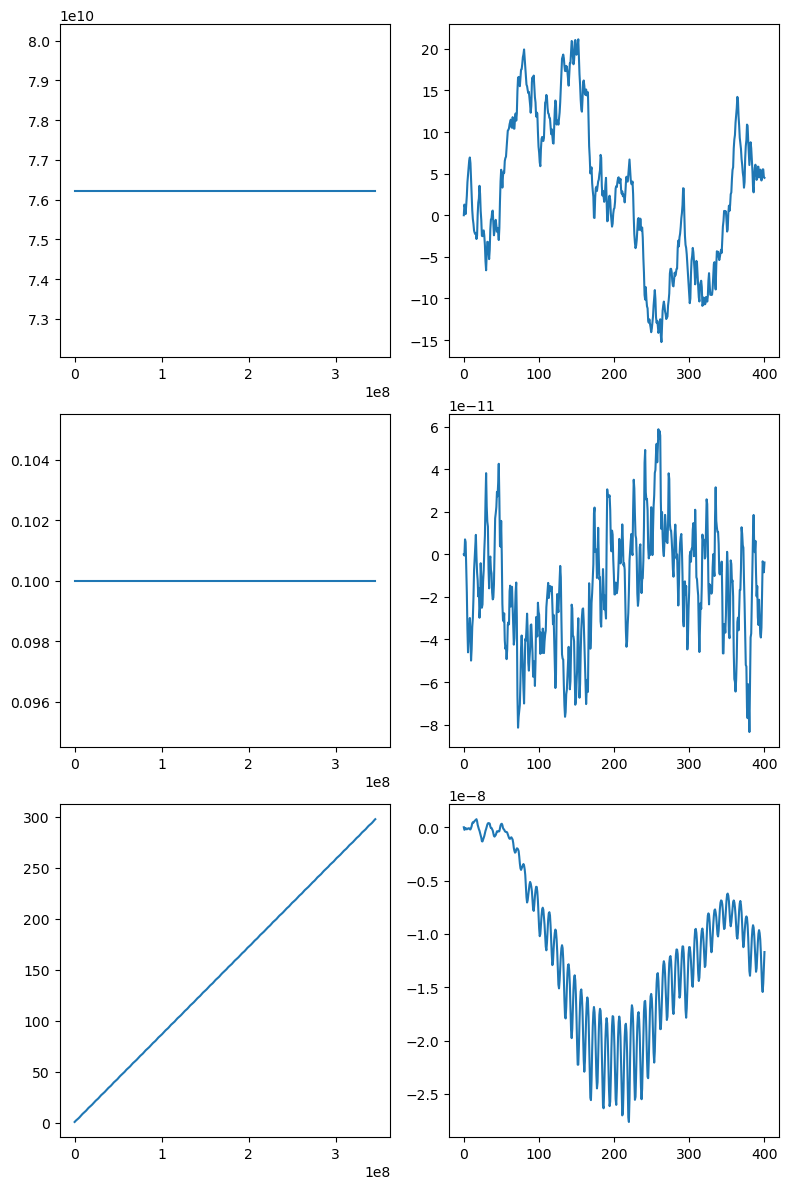

In [9]:
fig, ax  = plt.subplots(3,2, figsize=(8,12))
ax = np.ravel(ax)

ax[0].plot(t_eval, result.y[0,:])
ax[1].plot(t_eval/10/day, GAMMA_1[0,:])
ax[2].plot(t_eval, result.y[1,:])
ax[3].plot(t_eval/10/day, GAMMA_1[1,:])
ax[4].plot(t_eval, result.y[5,:])
ax[5].plot(t_eval/10/day, GAMMA_1[5,:])

plt.tight_layout()

# testing to see if pulsars require relativistic treatment

In [4]:
def gamma0_dot_nr(t, vec, args):
    gamma0 = vec
    p,e,inc,Omg,omg,f = gamma0

    m1,m2 = args
    M_tot = m1+m2
    
    M = M_mat(gamma0, args)
    E = E_mat(gamma0, args)

    eta = m1*m2/M_tot**2
    P = np.sqrt(4*np.pi**2/G/M_tot * (p/(1-e**2))**3)
    g = np.sqrt(1-e**2)
    vp = (2*np.pi*G*M_tot/P)**(1/3)
    
    F0 = np.array([0,0,0,0,0,np.sqrt(G*M_tot/p**3)*(1+e*np.cos(f))**2])

    return F0

def phi_nr(t_eval, gammas, args):

    m1,m2 = args
    M_tot = m1+m2
    
    p,e,inc,Omg,omg = gammas[:5,0]
    f = gammas[5,:]
    f0 = f[0]
    E = np.arctan(2*np.sqrt((1-e)/(1+e))*np.tan(f/2))
    E0 = E[0]
    P = np.sqrt(4*np.pi**2/G/M_tot * (p/(1-e**2))**3)

    phi = np.zeros((6,6,len(t_eval)))
    phi[-1,0,:] = -3*np.pi*(1+e*np.cos(f))**2 * t_eval/P / p / (1-e**2)**(3/2)
    phi[-1,1,:] = (-6*np.pi*e*(1+e*np.cos(f))**2*t_eval/P/(1-e**2)**(5/2) +
                   (2-e**2)/np.sqrt(1-e**2)*(np.sin(E)-np.sin(E0))/(1-e*np.cos(E))**2 -
                   e/2/np.sqrt(1-e**2)*(np.sin(2*E)-np.sin(2*E0))/(1-e*np.cos(E))**2)
    phi[-1,-1,:] = -1 + ((1+e*np.cos(f))/(1+e*np.cos(f0)))**2

    for ii in range(6):
        phi[ii,ii,:] += 1

    return phi

In [11]:
seed = 1234
nr = np.random.default_rng(seed)

In [12]:
result_nr = solve_ivp(gamma0_dot_nr, (0,t_eval[-1]), gamma_0, args=[args_0], t_eval=t_eval)

In [13]:
phis_nr = phi_nr(t_eval, result_nr.y, args_0)

In [14]:
freqs = np.linspace(0.5,10)/10/day

Faij_gw = F_aij_GW_across_t(t_eval, result_nr.y, args_0)
ddot_h_ij = np.zeros((3,3,len(t_eval)))
for ff in freqs:
    h_ad_ij = ddot_h_ad_ij(t_eval,ff)
    gw = Omega_gw(ff)
    sig = 6*np.pi**2/5*gw*ff*H0**2
    A = nr.normal(loc=0,scale=sig**0.5, size=(2,5))

    ddot_h_ij += np.einsum('da,daijt->ijt', A, h_ad_ij)

F1_a_nr = np.einsum('aijt,ijt->at', Faij_gw, ddot_h_ij)
A

array([[-5.69036258e-24,  1.44497719e-23,  3.26814483e-24,
         9.37100624e-24,  8.32135070e-24],
       [ 1.43505432e-23,  8.99931724e-24,  9.73691090e-24,
        -5.24952066e-24, -1.02321584e-23]])

In [15]:
INTGL_nr = []
for tt in range(len(t_eval)):
    I_nr = np.linalg.solve(phis_nr[...,tt], F1_a_nr[:,tt])
    INTGL_nr.append(I_nr)

INTGL_nr = np.array(INTGL_nr).T
integrated_nr = sint.cumulative_trapezoid(INTGL_nr, x=t_eval, axis=1, initial=0)
GAMMA_1_nr = np.einsum('abt,bt->at', phis_nr, integrated_nr)

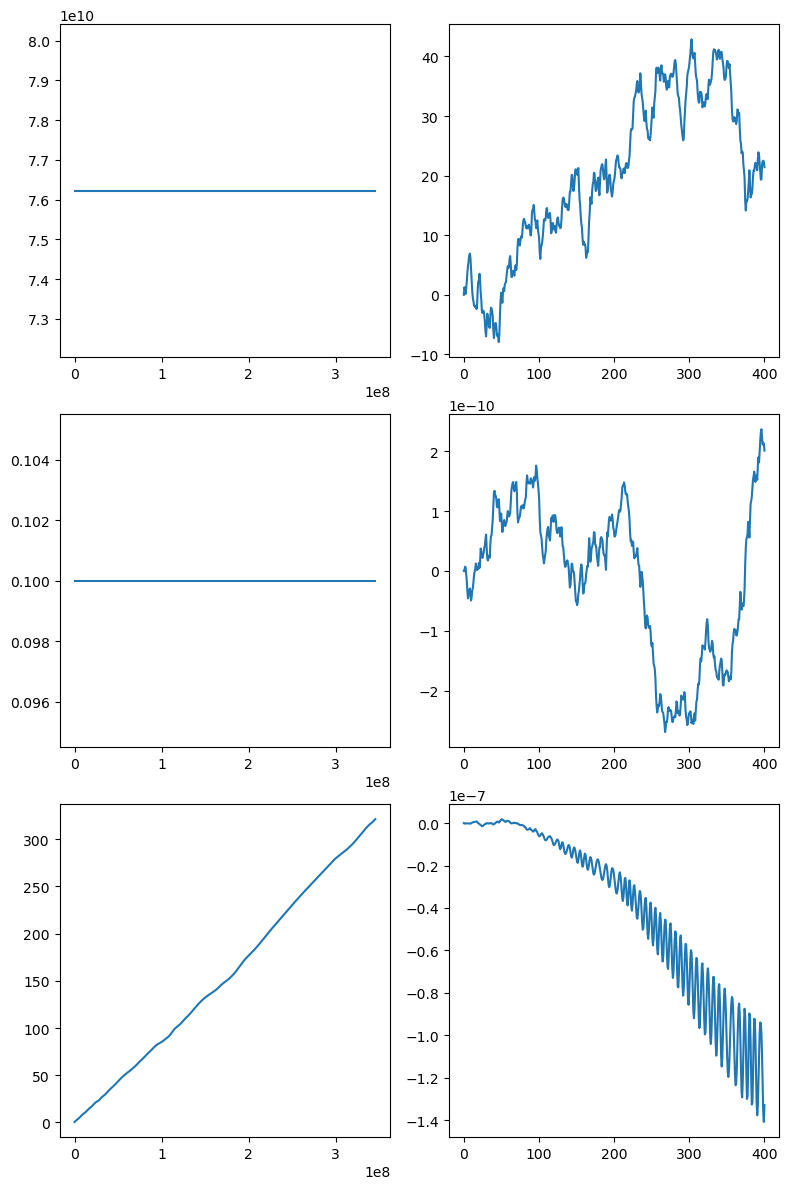

In [16]:
fig, ax  = plt.subplots(3,2, figsize=(8,12))
ax = np.ravel(ax)

ax[0].plot(t_eval, result_nr.y[0,:])
ax[1].plot(t_eval/10/day, GAMMA_1_nr[0,:])
ax[2].plot(t_eval, result_nr.y[1,:])
ax[3].plot(t_eval/10/day, GAMMA_1_nr[1,:])
ax[4].plot(t_eval, result_nr.y[5,:])
ax[5].plot(t_eval/10/day, GAMMA_1_nr[5,:])

plt.tight_layout()

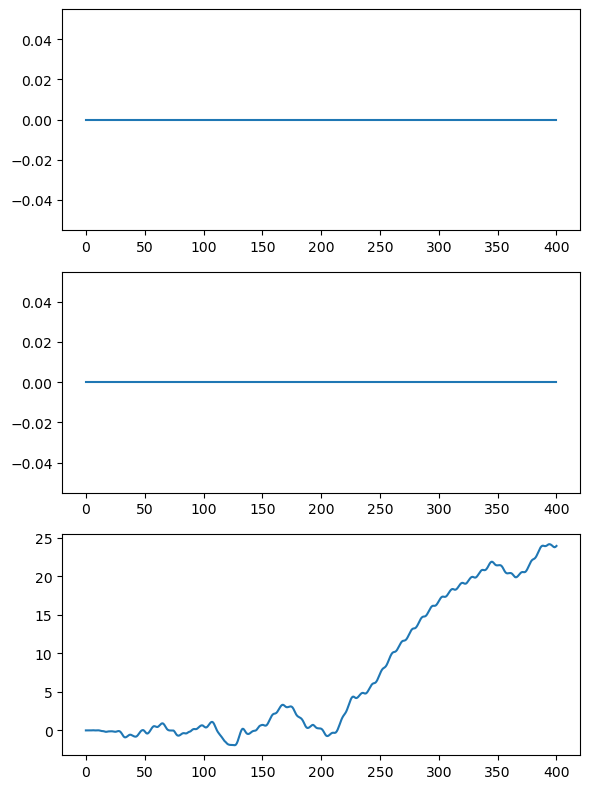

In [17]:
diff = result_nr.y - result.y[:6,:]

fig, ax  = plt.subplots(3,1, figsize=(6,8))
ax = np.ravel(ax)

ax[0].plot(t_eval/10/day, diff[0,:])
ax[1].plot(t_eval/10/day, diff[1,:])
ax[2].plot(t_eval/10/day, diff[-1,:])

plt.tight_layout()

# Trying to make both simultaneously

In [18]:
seed = 1234
nr = np.random.default_rng(seed)

In [19]:
result = solve_ivp(gamma0_phi_dot, (0,t_eval[-1]), np.array([*gamma_0,*np.eye(6).flatten()]), args=[args_0], t_eval=t_eval)
result_nr = solve_ivp(gamma0_dot_nr, (0,t_eval[-1]), gamma_0, args=[args_0], t_eval=t_eval)

In [20]:
phis_nr = phi_nr(t_eval, result_nr.y, args_0)
phis = result.y[6:,:].reshape((6,6,len(t_eval)))

In [21]:
freqs = np.linspace(0.5,10)/10/day

Faij_gw_nr = F_aij_GW_across_t(t_eval, result_nr.y, args_0)
Faij_gw = F_aij_GW_across_t(t_eval, result.y[:6,:], args_0)
ddot_h_ij = np.zeros((3,3,len(t_eval)))
for ff in freqs:
    h_ad_ij = ddot_h_ad_ij(t_eval,ff)
    gw = Omega_gw(ff)
    sig = 6*np.pi**2/5*gw*ff*H0**2
    A = nr.normal(loc=0,scale=sig**0.5, size=(2,5))

    ddot_h_ij += np.einsum('da,daijt->ijt', A, h_ad_ij)

F1_a_nr = np.einsum('aijt,ijt->at', Faij_gw_nr, ddot_h_ij)
F1_a = np.einsum('aijt,ijt->at', Faij_gw, ddot_h_ij)

In [22]:
INTGL_nr = []
INTGL = []
for tt in range(len(t_eval)):
    I_nr = np.linalg.solve(phis_nr[...,tt], F1_a_nr[:,tt])
    INTGL_nr.append(I_nr)
    I = np.linalg.solve(phis[...,tt], F1_a[:,tt])
    INTGL.append(I)

INTGL_nr = np.array(INTGL_nr).T
INTGL = np.array(INTGL).T
integrated_nr = sint.cumulative_trapezoid(INTGL_nr, x=t_eval, axis=1, initial=0)
GAMMA_1_nr = np.einsum('abt,bt->at', phis_nr, integrated_nr)
integrated = sint.cumulative_trapezoid(INTGL, x=t_eval, axis=1, initial=0)
GAMMA_1 = np.einsum('abt,bt->at', phis, integrated)

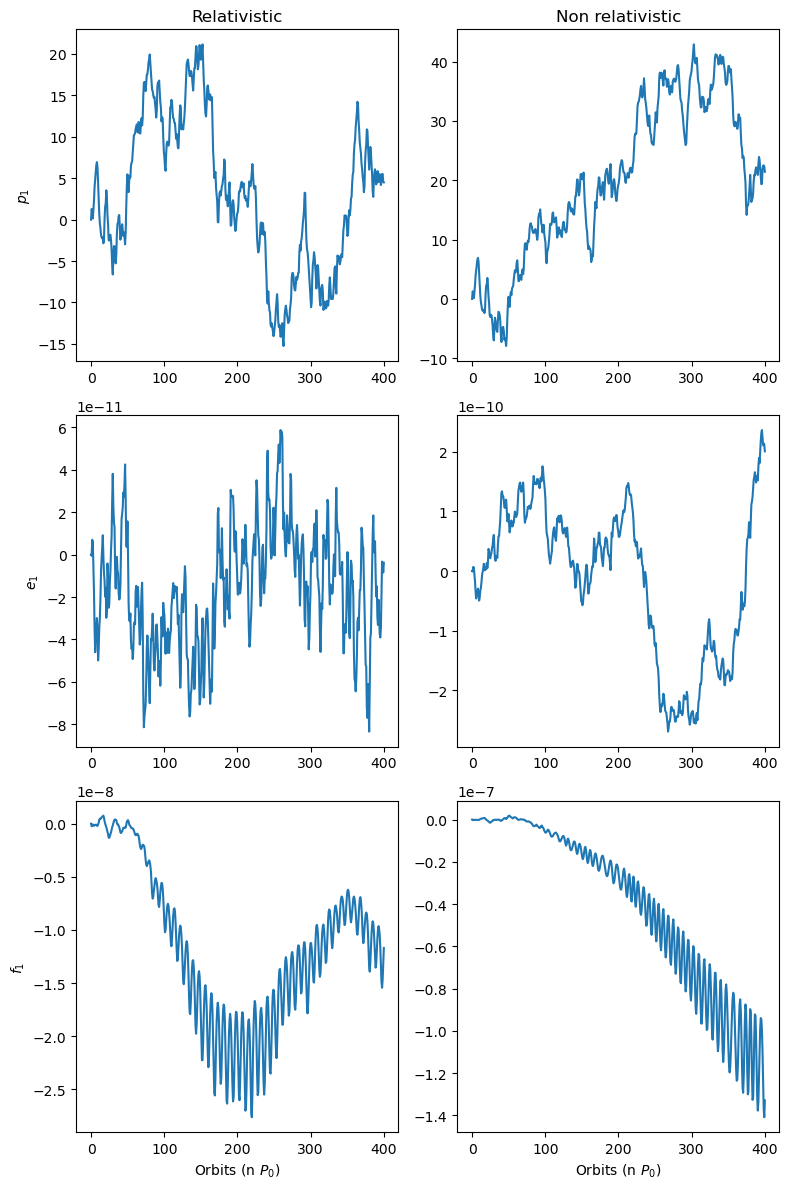

In [23]:
fig, ax  = plt.subplots(3,2, figsize=(8,12))
ax = np.ravel(ax)

ax[0].plot(t_eval/10/day, GAMMA_1[0,:])
ax[0].set_title('Relativistic')
ax[1].plot(t_eval/10/day, GAMMA_1_nr[0,:])
ax[1].set_title('Non relativistic')
ax[2].plot(t_eval/10/day, GAMMA_1[1,:])
ax[3].plot(t_eval/10/day, GAMMA_1_nr[1,:])
ax[4].plot(t_eval/10/day, GAMMA_1[5,:])
ax[5].plot(t_eval/10/day, GAMMA_1_nr[5,:])

ax[0].set_ylabel(r'$p_1$')
ax[2].set_ylabel(r'$e_1$')
ax[4].set_ylabel(r'$f_1$')

ax[-1].set_xlabel('Orbits (n $P_0$)')
ax[-2].set_xlabel('Orbits (n $P_0$)')

plt.tight_layout()

In [24]:
phis[...,1]

array([[ 1.00000000e+00,  1.04554414e-07, -6.90817587e-10,
         5.83993743e-09,  5.83964544e-09, -2.91763284e-09],
       [-2.17266680e-29,  1.00000000e+00, -6.37950784e-21,
        -2.73468610e-19, -2.73490894e-19, -1.00043087e-18],
       [-7.61495875e-33, -2.33389546e-22,  1.00000000e+00,
        -1.13848709e-39, -4.10722565e-21, -3.98346380e-21],
       [-1.96180229e-29,  6.67917334e-19,  3.40567711e-33,
         1.00000000e+00,  1.11999647e-19,  5.54729637e-20],
       [-3.90393333e-28, -6.73725241e-17, -8.39791536e-20,
         3.58246979e-18,  1.00000000e+00,  7.69541846e-18],
       [-1.27417789e-11,  7.66899803e-01,  6.85665087e-20,
        -3.30181191e-18, -3.30194600e-18,  9.08460333e-01]])

In [25]:
phis_nr[...,1]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.27450420e-11,  5.74967891e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  9.08440137e-01]])

In [ ]:
"J0613-0200", "J0740+6620", "J1600-3053", "J1614-2230", "J1630+3734", "J1640+2224", "J1741+1351", "J1811-2405", "J1853+1303", "B1855+09", "J1903+0327", "J1909-3744", "J1918-0642", "J1946+3417", "J2017+0603", "J2043+1711", "J2302+4442"
mp = 3.2, 1.99, 1.2, 1.937, 6.3, 2.8, 0.83, 2.1, 1.8, 1.563, 0.94, 1.57, 1.31, 3.9, 2.0, 1.62, 5.2
pb = 1.2, 4.8, 14.3, 8.7, 12.5, 175.5, 16.3, 6.3, 115.7, 12.3, 95.2, 1.5, 10.9, 27, 2.2, 1.5, 125.9

# Functions for constructing the covariance matrix across multiple frequencies

In [5]:
def gamma_1_aid_freq(t_eval, gamma, args, freqs):

    m1,m2 = args
    M_tot = m1+m2
    p,e,inc,Omg,omg,f = gamma

    result_0 = solve_ivp(gamma0_phi_dot, (0,t_eval[-1]), np.array([*gamma,*np.eye(6).flatten()]), args=[args], t_eval=t_eval)
    phis = result_0.y[6:,:].reshape((6,6,len(t_eval)))
    gamma0s = result_0.y[:6,:]

    F_aijgw = F_aij_GW_across_t(t_eval, gamma0s, args)
    ddot_h_tf = np.array([ddot_h_ad_ij(t_eval,ff) for ff in freqs])

    INTGL = []
    for tt in range(len(t_eval)):
        I = np.einsum('ab,blm,fdilm-> adif', np.linalg.inv(phis[...,tt]), F_aijgw[...,tt], ddot_h_tf[...,tt])
        INTGL.append(I)

    INTGL = np.array(INTGL).transpose(1,2,3,4,0) # Shape should be 6 x 2 x 5 x n_freq x n_tobs
    II = sint.cumulative_trapezoid(INTGL, x=t_eval, initial=0, axis=-1)
    gam_aid_f = np.einsum('abt,bdift-> adift', phis, II)

    return gam_aid_f

def dels(t, gamma, args):
    m1,m2 = args
    p,e,inc,Omg,omg,f = gamma
    E0 = 2*sp.atan(sp.sqrt((1-e)/(1+e)) * sp.tan(f/2))

    del_r = m2*p/c*sp.sin(inc)/(1-e**2)/(m1+m2)*( (sp.cos(E0)-e)*sp.sin(omg) + sp.sqrt(1-e**2)*sp.sin(E0)*sp.cos(omg) )
    del_s = -2*G*m2/c**3*sp.log(1 - e*sp.cos(E0) - sp.sin(inc)*(sp.sin(omg)*(sp.cos(E0)-e) + sp.sqrt(1-e**2)*sp.cos(omg)*sp.sin(E0)))
    del_e = 1/c**2*sp.sqrt(G*e**2*p/(1-e**2)) * m2*(m1+2*m2)/(m1+m2)**(3/2) * sp.sin(E0)

    return del_r + del_s + del_e

T_a = dels(t,gamma,args).diff(gamma)

timing_data = sp.lambdify([t,gamma, args], T_a, modules='numpy')

def GAM1_idf(t_eval, gamma, args, freqs):

    m1,m2 = args
    M_tot = m1+m2
    p,e,inc,Omg,omg,f = gamma

    result_0 = solve_ivp(gamma0_phi_dot, (0,t_eval[-1]), np.array([*gamma,*np.eye(6).flatten()]), args=[args], t_eval=t_eval)
    phis = result_0.y[6:,:].reshape((6,6,len(t_eval)))
    gamma0s = result_0.y[:6,:]

    F_aijgw = F_aij_GW_across_t(t_eval, gamma0s, args)
    ddot_h_tf = np.array([ddot_h_ad_ij(t_eval,ff) for ff in freqs])

    INTGL = []
    for tt in range(len(t_eval)):
        I = np.einsum('ab,blm,fdilm-> adif', np.linalg.inv(phis[...,tt]), F_aijgw[...,tt], ddot_h_tf[...,tt])
        INTGL.append(I)

    INTGL = np.array(INTGL).transpose(1,2,3,4,0) # Shape should be 6 x 2 x 5 x n_freq x n_tobs
    II = sint.cumulative_trapezoid(INTGL, x=t_eval, initial=0, axis=-1)
    Ta = np.array([timing_data(tt, result.y[:6,tt], args_0) for tt in range(len(t_eval))]).T
    g1_idf = np.einsum('at,abt,bdift-> dift', Ta, phis, II)

    return g1_idf

In [44]:
G1_aidf = gamma_1_aid_freq(t_eval, gamma_0, args_0, np.arange(1,11)/10/day)

In [45]:
G1_aidf.shape

(6, 2, 5, 10, 500)

In [54]:
G1_IDF = GAM1_idf(t_eval, gamma_0, args_0, np.arange(1,11)/10/day)

In [55]:
G1_IDF.shape

(2, 5, 10, 500)

In [6]:
class binary_evolution():
    """
    Class for generating orbital evolution at 0th and 1st order

    t_eval: The observation times
    gamma: Initially measured orbital parameters [p, e, inc, Omg, omg, f]
    args: The masses of the pulsar and companion [m_p, m_b]
    freqs: Frequency bins of interest
    gw_func: The GWB energy density spectrum (Omega_GW(f)) as a function of frequency
             with other parameters fixed (e.g. amplitude, spectral index), can be
             updated using update_gw_func
    sigma: The uncertainties at each observing time
    rel: Boolean, whether to treat the binary as relativistic or not, default is False
    seed: For testing purposes and testing the pseudorandom number generation

    Can draw random values of the gaussian variable A_nu^i,d as well as random draws
    of 1st order perturbations
    """
    def __init__(self, t_eval, gamma, args, freqs, gw_func, sigma, rel=False, seed=None):

        self.nr = np.random.default_rng(seed)
        self.time = t_eval
        self.err = sigma
        self.initial_params = gamma
        self.masses = args
        self.freqs = freqs
        self.relativistic = rel

        # Fixed values
        self.g0 = self.zero_order_evo()
        self.cov_tensor = self.cov_mat_constructor()

        # GWB dependent values
        self.gw = gw_func
        self.A_var = self.variance_A()

    def update_gw_func(self, GW_FUNC):
        """
        If using an MCM or Bayesian analysis it may be helpful to only update the GWB
        rather than intiializing gamma_0 and gamma_1^id all over again
        Also updates the variance associated with the gaussian variables
        """
        self.gw = GW_FUNC
        self.A_var = self.variance_A()

    def variance_A(self):
        """
        Calculate the variance of the gaussian amplitude
        variables as defined by Eqn 60.
        These values are fixed for a given GWB
        """
        return 6*np.pi**2/5*self.gw(self.freqs)*self.freqs*H0**2

    def zero_order_evo(self):
        """
        Evolve the zeroth order orbital parameters (for both relativistic
        and non-relativistic binaries).
        This step only needs to be done once and is not dependent on the GWB
        """
        if self.relativistic:
            print('Assuming relativistic binary, dense fundamental matrix')
            result = solve_ivp(gamma0_phi_dot, (0,self.time[-1]), np.array([*self.initial_params,*np.eye(6).flatten()]),
                               args=[self.masses], t_eval=self.time)
            gamma0 = result.y[:6,:]
            phis = result.y[6:,:].reshape((6,6,len(t_eval)))

        else:
            result_nr = solve_ivp(gamma0_dot_nr, (0,self.time[-1]), self.initial_params, args=[self.masses], t_eval=self.time)
            gamma0 = result_nr.y
            phis = phi_nr(self.time, result_nr.y, self.masses)

        return gamma0, phis

    def gamma1_aidf(self):
        """
        Construct the intermediate tensor used for the covariance
        matrix gamma_1^alpha,i,d for multiple frequencies
        Eqn 61
        """
        gam0, phis = self.g0

        F_aijgw = F_aij_GW_across_t(self.time, gam0, self.masses)
        ddot_h_tf = np.array([ddot_h_ad_ij(self.time,ff) for ff in self.freqs])
        
        INTGL = []
        for tt in range(len(self.time)):
            I = np.einsum('ab,blm,fdilm-> adif', np.linalg.inv(phis[...,tt]), F_aijgw[...,tt], ddot_h_tf[...,tt])
            INTGL.append(I)
    
        INTGL = np.array(INTGL).transpose(1,2,3,4,0) # Shape should be 6 x 2 x 5 x n_freq x n_tobs
        II = sint.cumulative_trapezoid(INTGL, x=t_eval, initial=0, axis=-1)
        gam_aid_f = np.einsum('abt,bdift-> adift', phis, II)

        return gam_aid_f

    def cov_mat_constructor(self):
        """
        Takes the $gamma_1^alpha,i,d,nu$ values and tensor
        sums them with the timing mapping.
        Returns a tensor that is 2 x 5 x n_freq x n_tobs
        Useful for calculating Eqn 106 quickly
        """
        gam0 = self.g0[0]
        Ta = np.array([timing_data(tt, gam0[:,tt], self.masses) for tt in range(len(t_eval))]).T
        g1_aidf = self.gamma1_aidf()

        G1_idf = np.einsum('at,adift->dift', Ta, g1_aidf)

        return G1_idf

    def rand_A(self):
        """
        Draw a random value of the gaussian variables that control the GW amplitude
        Returns a tensor that is 2 x 5 x n_freq
        """
        A = np.zeros((2,5,len(self.freqs)))
        gw = self.gw(self.freqs)
        sig = 6*np.pi**2/5*gw*self.freqs*H0**2
        for ff in range(len(self.freqs)):
            A[...,ff] = self.nr.normal(loc=0,scale=sig[ff]**0.5, size=(2,5))
        return A

    def rand_g1_draw(self, sum_freq=True):
        """
        Eqn 62, can either sum across all frequencies or get frequency dependent
        1st order corrections
        """
        g1_aidf = self.gamma1_aidf()
        A = self.rand_A()
        if sum_freq:
            return np.einsum('dif,adift-> at', A, g1_aidf)
        else:
            return np.einsum('dif,adift-> aft', A, g1_aidf)

    def covariance_matrix(self):
        """
        Construct the total covariance matrix for random
        Eqn 106
        """
        GAM1_idf = self.cov_tensor
        A = np.repeat(self.A_var, 10).reshape((len(self.freqs),5,2))

        return np.einsum('dift,fid,difT-> tT', GAM1_idf, A, GAM1_idf) + np.diag(self.err)

    def time_delay_draw(self, sum_freq=True):

        m1,m2 = self.masses
        g0 = self.g0[0]

        if sum_freq:
            g1 = self.rand_g1_draw(sum_freq=True)
            g_tot = g1 + g0

            p,e,inc,Omg,omg,f = g_tot
            E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(f/2))
            del_r = m2*p/c*np.sin(inc)/(1-e**2)/(m1+m2)*( (np.cos(E0)-e)*np.sin(omg) + np.sqrt(1-e**2)*np.sin(E0)*np.cos(omg) )
            del_s = -2*G*m2/c**3*np.log(1 - e*np.cos(E0) - np.sin(inc)*(np.sin(omg)*(np.cos(E0)-e) + np.sqrt(1-e**2)*np.cos(omg)*np.sin(E0)))
            del_e = 1/c**2*np.sqrt(G*e**2*p/(1-e**2)) * m2*(m1+2*m2)/(m1+m2)**(3/2) * np.sin(E0)
        else:
            g1_f = self.rand_g1_draw(sum_freq=False)
            g_tot_f = g1_f + g0[:,None,:]
            
            p,e,inc,Omg,omg,f = g_tot_f
            E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(f/2))
            del_r = m2*p/c*np.sin(inc)/(1-e**2)/(m1+m2)*( (np.cos(E0)-e)*np.sin(omg) + np.sqrt(1-e**2)*np.sin(E0)*np.cos(omg) )
            del_s = -2*G*m2/c**3*np.log(1 - e*np.cos(E0) - np.sin(inc)*(np.sin(omg)*(np.cos(E0)-e) + np.sqrt(1-e**2)*np.cos(omg)*np.sin(E0)))
            del_e = 1/c**2*np.sqrt(G*e**2*p/(1-e**2)) * m2*(m1+2*m2)/(m1+m2)**(3/2) * np.sin(E0)
        
        return del_r + del_s + del_e

In [7]:
BE_nonrel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.arange(1,11)/10/day, gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=False)

In [8]:
BE_rel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.arange(1,11)/10/day, gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=True)

Assuming relativistic binary, dense fundamental matrix


Text(0.5, 1.0, 'Differences in autocovariance between rel. and non-rel. for multiple freqs')

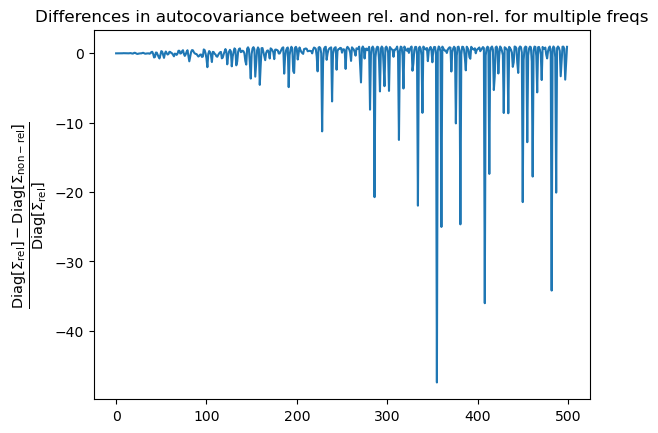

In [9]:
plt.plot((np.diag(BE_rel.covariance_matrix())-
          np.diag(BE_nonrel.covariance_matrix()))
         /np.diag(BE_rel.covariance_matrix()))
plt.ylabel(r'$\frac{\mathrm{Diag}[\Sigma_\mathrm{rel}] - \mathrm{Diag}[\Sigma_\mathrm{non-rel}]}{\mathrm{Diag}[\Sigma_\mathrm{rel}]}$', fontsize=15)
plt.title('Differences in autocovariance between rel. and non-rel. for multiple freqs')

In [10]:
BE_nonrel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.array([1/10/day]), gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=False)

In [11]:
BE_rel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.array([1/10/day]), gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=True)

Assuming relativistic binary, dense fundamental matrix


Text(0.5, 1.0, 'Differences in autocovariance between rel. and non-rel. for a single freq')

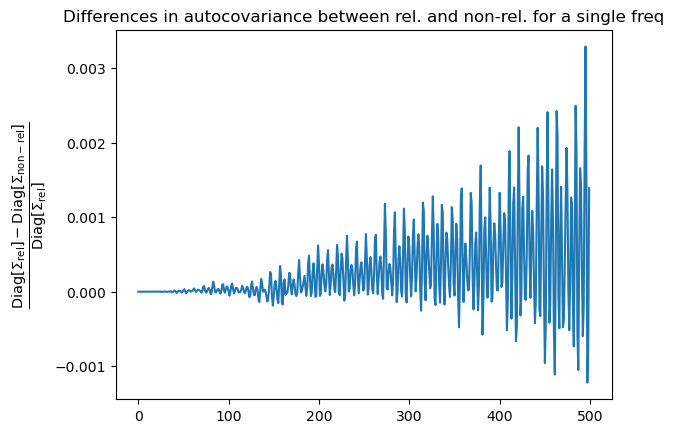

In [12]:
plt.plot((np.diag(BE_rel.covariance_matrix())-
          np.diag(BE_nonrel.covariance_matrix()))
         /np.diag(BE_rel.covariance_matrix()))
plt.ylabel(r'$\frac{\mathrm{Diag}[\Sigma_\mathrm{rel}] - \mathrm{Diag}[\Sigma_\mathrm{non-rel}]}{\mathrm{Diag}[\Sigma_\mathrm{rel}]}$', fontsize=15)
plt.title('Differences in autocovariance between rel. and non-rel. for a single freq')

In [13]:
BE_nonrel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.arange(1,11)/10/day, gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=False, seed=1234)

In [14]:
BE_rel = binary_evolution(t_eval, gamma_0, args_0, freqs=np.array([1/10/day]), gw_func=Omega_gw, sigma=np.ones(500)/1e20, rel=True, seed=1234)

Assuming relativistic binary, dense fundamental matrix


In [15]:
dt_nonrel = BE_nonrel.time_delay_draw()
dt_rel = BE_rel.time_delay_draw()

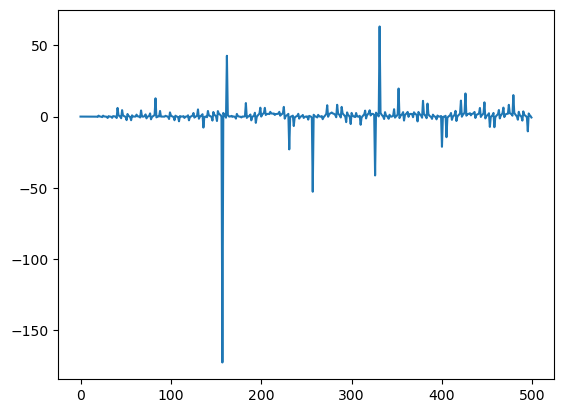

In [16]:
plt.plot((dt_rel-dt_nonrel)/dt_rel)